# Motivation
After playing around with a couple of off-the-shelf OCR engines, I decided to try my hand at creating my own model. I want something that's lightweight and accurate.

In this notebook, I'm going to try my hand at training a convolutional neural network to detect Boggle letters. 

# Setup
The cells below will set up the rest of the notebook. 

I'll start by configuring the kernel: 

In [1]:
# Change the directory to the root of the repo 
%cd ..

# Enable the autoreload extension
%load_ext autoreload
%autoreload 2

d:\data\programming\boggle-vision


Now that the kernel is configured, I'm going to load in some modules.

In [2]:
# General import statements
import os
import pandas as pd
from pathlib import Path
from tqdm import tqdm

# Pytorch-related import statements
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torch.utils.data import random_split
import torch.nn as nn
import torch.optim as optim

# Importing custom modules from this repo
from utils.settings import allowed_boggle_tiles

# Loading Data
I'm going to start by creating a custom `Dataset` for my network, and by specifying a `DataLoader`. Since it's been a bit, I'm going to follow [the Pytorch documentation](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) for this.

I'll start with the `Dataset`, which I'll call a `BoggleTileImageDataset`:

In [3]:
class BoggleTileImageDataset(Dataset):
    """
    This is a custom Dataset for handling the Boggle tile images.
    """

    def __init__(self, image_directory):
        """
        This is the initialization method. Here, I'll set some class variables
        for the image directory and the image paths.
        """

        # Set the img_dir class variable
        self.img_dir = image_directory
        
        # Create a mapping of letters to integers
        self.letter_to_int_dict = {letter: idx for idx, letter in enumerate(allowed_boggle_tiles)}

        # Create a class variable mapping each of the image paths to their labels
        self.img_path_to_label_dict = {}
        for child_file in Path(image_directory).iterdir():
            if child_file.suffix == ".png":
                cur_file_letter = child_file.name.split("_")[0]
                self.img_path_to_label_dict[child_file] = cur_file_letter

    def __len__(self):
        """
        This method will return the length of the dataset.
        """
        return len(self.img_path_to_label_dict)

    def __getitem__(self, idx):
        """
        This method will return the image and the label for a given index.
        """
        img_path = list(self.img_path_to_label_dict.keys())[idx]
        img = read_image(str(img_path)).float()
        label = self.img_path_to_label_dict[img_path]
        label_int = self.letter_to_int_dict[label]
        label = torch.tensor(label_int)
        return img, label

With this custom `Dataset` in hand, I'm going to create an instance of it (as well as an accompanying `DataLoader`).  

In [4]:
# Loading in the full dataset
full_dataset = BoggleTileImageDataset("data/training-data")

# Calculate lengths for each split
train_length = int(0.93 * len(full_dataset))
val_length = int(0.05 * len(full_dataset))
test_length = len(full_dataset) - train_length - val_length

# Split the dataset
train_data, val_data, test_data = random_split(full_dataset, [train_length, val_length, test_length])

# Create DataLoaders
batch_size = 256
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

**MISC:** Below, I can show one of the images from the training data, as well as its corresponding label:

Feature batch shape: torch.Size([256, 1, 100, 100])
Labels batch shape: torch.Size([256])


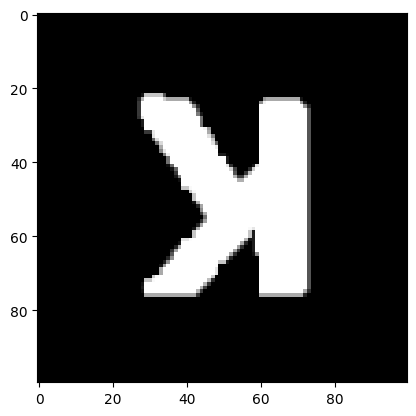

Label: 10 (K)


In [5]:
from matplotlib import pyplot as plt
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label} ({allowed_boggle_tiles[label]})")

# Defining Network Architecture
Next, I'm going to define an architecture for the network. 

In [6]:
class BoggleCNN(nn.Module):
    def __init__(self, num_classes):
        super(BoggleCNN, self).__init__()
        
        # Convolutional layers
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        # Placeholder for the feature map size, to be filled in later
        self.feature_map_size = None 
        
        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Linear(1, 128),  # Placeholder size, will adjust dynamically
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)  # Pass through the convolutional layers
        
        # Dynamically calculate the feature map size if not done already
        if self.feature_map_size is None:
            self.feature_map_size = x.size(1) * x.size(2) * x.size(3)
            self.classifier[0] = nn.Linear(self.feature_map_size, 128)  # Adjust the FC layer size
            
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.classifier(x)     # Pass through the fully connected layers
        return x
    
class EnhancedBoggleCNN(nn.Module):
    def __init__(self, num_classes):
        super(EnhancedBoggleCNN, self).__init__()
        
        # More Convolutional layers
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(128, 256, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        # Placeholder for the feature map size, to be filled in later
        self.feature_map_size = None
        
        # More Fully connected layers
        self.classifier = nn.Sequential(
            nn.Linear(1, 256),  # Placeholder size, will adjust dynamically
            nn.ReLU(),
            nn.Dropout(0.5),  # Added Dropout to prevent overfitting
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),  # Added Dropout to prevent overfitting
            
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        
        # Dynamically calculate the feature map size
        if self.feature_map_size is None:
            self.feature_map_size = x.size(1) * x.size(2) * x.size(3)
            self.classifier[0] = nn.Linear(self.feature_map_size, 256)
            
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


# Create the model
model = EnhancedBoggleCNN(num_classes=len(allowed_boggle_tiles))

We're also going to define a loss function and optimizer: 

In [7]:
# Define the loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
Next, I'm going to run through the training loop:

In [8]:
# Iterate through the data 
epoch_amt = 5
for epoch in range(epoch_amt):
    
    # We're going to keep track of the loss for each epoch
    epoch_loss = 0
    
    # Iterate through the data
    for (data, target) in tqdm(train_loader):
        
        # Zero out the gradients
        optimizer.zero_grad()
        
        # Make predictions
        output = model(data)
        
        # Calculate the loss
        loss = loss_function(output, target)
        
        # Backpropagate the loss
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
        # Add the loss to the epoch loss
        epoch_loss += loss.item()
        
    # Print the epoch loss
    print(f"Epoch {epoch + 1} loss: {epoch_loss / len(train_loader)}")

100%|██████████| 45/45 [01:19<00:00,  1.77s/it]


Epoch 1 loss: 2.9983075168397693


100%|██████████| 45/45 [00:57<00:00,  1.28s/it]


Epoch 2 loss: 0.9846450726191203


100%|██████████| 45/45 [01:03<00:00,  1.40s/it]


Epoch 3 loss: 0.37852620085080463


100%|██████████| 45/45 [01:04<00:00,  1.43s/it]


Epoch 4 loss: 0.19647077967723212


100%|██████████| 45/45 [01:05<00:00,  1.46s/it]

Epoch 5 loss: 0.14040122876564662


# Testing Loop 
Now that we've got a trained model, we ought to test it on the test data. 

In [9]:
# Calculate the accuracy on the test set
correct = 0
total = 0

# Iterate through the test set
for (data, target) in tqdm(test_loader):
        
        # Make predictions
        output = model(data)
        
        # Get the predicted class
        _, predicted = torch.max(output.data, 1)
        
        # Add the number of correct predictions to the total correct
        total += target.size(0)
        correct += (predicted == target).sum().item()

# Print the accuracy
print(f"Accuracy on the test set: {correct / total}")

100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

Accuracy on the test set: 0.97165991902834


# Saving the Model
Now that we've created a model, we ought to save it to disk. 

In [10]:
# Create a path to save the model
model_folder = Path("models")
model_folder.mkdir(exist_ok=True, parents=True)

# Save the model
torch.save(model.state_dict(), model_folder / "boggle_cnn.pth")